In [1]:
import copy
import numpy as np
import open3d as o3d
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
def create_heatmap(matrix, threshold):
    # Create a mask to identify values that are smaller than the threshold
    mask = matrix < threshold
    
    # Create a new matrix with masked values
    masked_matrix = np.ma.masked_where(~mask, matrix)
    
    # Create the heatmap using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(masked_matrix, cmap='hot', interpolation='nearest', vmin=matrix.min(), vmax=matrix.max())
    plt.colorbar()
    plt.title(f"Heatmap for Values < {threshold}")
    plt.show()

In [2]:
def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

In [3]:
# Inverse of a CDF related functions

def RationalApproximation(t):
    # Abramowitz and Stegun formula 26.2.23.
    # The absolute value of the error should be less than 4.5 e-4.
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    return t - ((c[2]*t + c[1])*t + c[0]) / (((d[2]*t + d[1])*t + d[0])*t + 1.0)

def NormalCDFInverse(p):
    # See article above for explanation of this section.
    if (p < 0.5):
        # F^-1(p) = - G^-1(p)
        return -RationalApproximation( np.sqrt(-2.0*np.log(p)) )
    else:
        # F^-1(p) = G^-1(1-p)
        return RationalApproximation( np.sqrt(-2.0*np.log(1-p)) ) 

In [4]:
def returnFinites(array):
    arr_isfinite = np.all(np.isfinite(array), axis=1)
    return array[arr_isfinite, :]

def draw_registration_result(source, target, transformation=np.eye(4)):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [5]:
def returnMetric(sum):
    num_points = 180
    laserRangeVaraince = 0.015933206879414907
    normalVariance = 2*laserRangeVaraince
    muHalfNormal = np.sqrt(2 * normalVariance / np.pi)
    varianceHalfNormal = normalVariance * (1 - (2/np.pi))
    metric = (sum - (muHalfNormal*num_points)) / np.sqrt(varianceHalfNormal*num_points)

    return metric


In [6]:
returnMetric(0)

-17.758066079929414

In [7]:
# saveFile = 'data_add/points_diff_scans_infV.npz'
saveFile = 'data/points_from_sim_ranges_inf.npz'

# load the two laser scans. they are already in a 4x1 format
diff_points_from_ranges = np.load(saveFile)
dspoints_p1_4x1 = returnFinites(diff_points_from_ranges['points_p1'])
dspoints_p2_4x1 = returnFinites(diff_points_from_ranges['points_p2'])

# create a point cloud object for open3d and input your points in there
source_pcd = o3d.geometry.PointCloud()
target_pcd = o3d.geometry.PointCloud()

source_pcd.points = o3d.utility.Vector3dVector(dspoints_p1_4x1[:, 0:3])
target_pcd.points = o3d.utility.Vector3dVector(dspoints_p2_4x1[:, 0:3])

threshold = 0.02*1e1
# draw_registration_result(source_pcd, target_pcd)

dists = source_pcd.compute_point_cloud_distance(target_pcd)

In [8]:
sum = 0
count = 0
for d in dists:
    # print("Distance: ", d)
    count += 1
    sum += d
print("Sum: ", sum)
print(count)

Sum:  9.299908368817023
209


In [9]:
alpha = 0.1
oneMinusAlpha = 1 - alpha
f_inv = NormalCDFInverse(oneMinusAlpha)

print("Metric: ", returnMetric(sum))
print("F^-1(1-alpha): ", f_inv)
# print(NormalCDFInverse(alpha))

Metric:  -11.316444987797645
F^-1(1-alpha):  1.281728756502709


In [10]:
saveFile = 'data_add/points_scan_dump.npz'
loadFile = np.load(saveFile)
points_array = loadFile['arr_0']
num_scans = len(points_array)
source_pcd = o3d.geometry.PointCloud()
target_pcd = o3d.geometry.PointCloud()

In [11]:
# to get the points score of the NxN matrix

distances = np.zeros((num_scans, num_scans))
psi = np.zeros((num_scans, num_scans))

for i in range(num_scans):
    scan1 = returnFinites(points_array[i])
    source_pcd.points = o3d.utility.Vector3dVector(scan1[:, 0:3])
    for j in range(i, num_scans):
        scan2 = returnFinites(points_array[j])
        target_pcd.points = o3d.utility.Vector3dVector(scan2[:, 0:3])
        dist = np.array(source_pcd.compute_point_cloud_distance(target_pcd))
        distances[i, j] = np.sum(dist)
        psi[i, j] = returnMetric(distances[i, j])

distances - symmetrize(distances)
psi = symmetrize(psi)

In [18]:
pairwiseMetric = np.zeros((len(psi-1)))
for i in range(len(psi)-1):
    print(i, i+1, psi[i, i+1])
    pairwiseMetric[i] = psi[i, i+1]

0 1 -10.777417577499667
1 2 -11.454927041091215
2 3 -11.15564822003256
3 4 -10.744079084609181
4 5 -10.453412182415954
5 6 -10.722695180634702
6 7 -10.714245212794578
7 8 -10.996641273374046
8 9 -11.125582191551931
9 10 -10.356811204812008
10 11 -10.170807608061134
11 12 -10.175849189691354
12 13 -8.230026433096123
13 14 -7.944039227527355
14 15 -8.35164408270164
15 16 -7.993618086053112
16 17 -8.89284735410875
17 18 -7.862622973008734
18 19 -8.776424802308307
19 20 -10.458404805576633
20 21 -9.439470151253023
21 22 -11.033479450418708
22 23 -9.26589981765317
23 24 -2.4315216528611305
24 25 -11.622633912024224
25 26 -12.312239558093752
26 27 -13.458162836125014
27 28 -13.90744741287058
28 29 -12.824054516776402
29 30 -12.20237013763736
30 31 -12.720773277634104
31 32 -12.326292426139679
32 33 -12.391951573112047
33 34 -10.095328346349213
34 35 -10.050096721618798
35 36 -14.410718858394292
36 37 -13.719756278692744
37 38 -9.843857268220058
38 39 -12.348038416832326
39 40 10.611425399710

In [ ]:
create_heatmap(psi, f_inv)

In [ ]:
# to get the points score for first against all other scans
first = returnFinites(points_array[0])

source_pcd = o3d.geometry.PointCloud()
source_pcd.points = o3d.utility.Vector3dVector(first[:, 0:3])
target_pcd = o3d.geometry.PointCloud()

distance_array = []

for points in points_array:
    points = returnFinites(points)
    target_pcd.points = o3d.utility.Vector3dVector(points[:, 0:3])
    dists = source_pcd.compute_point_cloud_distance(target_pcd)
    distance_array.append(dists)

distance_array = np.array(distance_array)

In [ ]:
dist_all_scans = np.sum(distance_array, axis=1)
metric_all_scans = returnMetric(dist_all_scans)
for i in range(len(dist_all_scans)):
    print("Distance: {}\t Metric: {}".format(dist_all_scans[i], metric_all_scans[i]))

In [ ]:
num_points = 180
laserRangeVaraince = 0.015933206879414907
normalVariance = 2*laserRangeVaraince
muHalfNormal = np.sqrt(2 * normalVariance / np.pi)
varianceHalfNormal = normalVariance * (1 - (2/np.pi))

In [ ]:
muHalfNormal*360

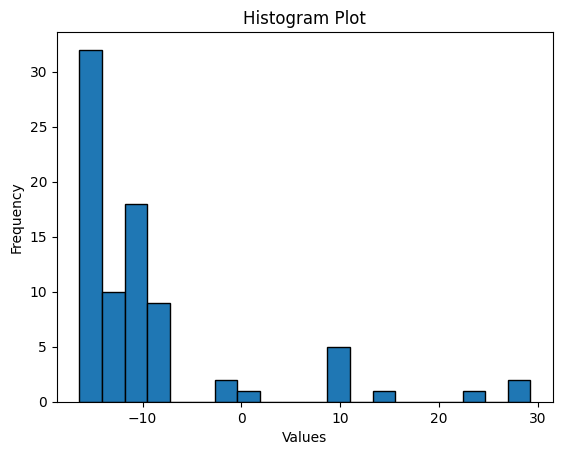

In [19]:
num_bins = 20

# x = np.linspace(np.min(pairwiseMetric), np.max(pairwiseMetric), 1000)  # Define x range for the PDF plot
# pdf = norm.pdf(x, loc=muHalfNormal*num_points, scale=varianceHalfNormal*num_points)

# Plot the histogram
plt.hist(pairwiseMetric, bins=num_bins, edgecolor='black')
# plt.plot(x, pdf, color='red', label='Standard Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram Plot')
plt.show()

In [ ]:
# kdtSearchParam = o3d.geometry.KDTreeSearchParamHybrid(5e-2, 1)
# source_feature = o3d.pipelines.registration.compute_fpfh_feature(source_pcd, kdtSearchParam)
# target_feature = o3d.pipelines.registration.compute_fpfh_feature(target_pcd, kdtSearchParam)

# correspondings = o3d.pipelines.registration.correspondences_from_features(source_feature, target_feature)

In [ ]:
sums = np.arange(100)
metrics = metric_and_cdf(sums)

In [ ]:
plt.plot(sums, metrics)
plt.show()